In [123]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import chess
import chess.svg
import chess.uci
from tqdm import tqdm

In [28]:
jogo = "1"

array_geral = np.load("Jogos/{}/array_geral_{}.npy".format(jogo, jogo))
array_jogadas = np.load("Jogos/{}/array_jogadas_{}.npy".format(jogo, jogo))

In [29]:
def jogo_ate_i(array_de_jogadas, i = 9999):
    board = chess.Board()
    for jogada in array_de_jogadas[:i]:
        board.push_uci(jogada)
    return board

def converte_notacao_xadrez_afonso(square_number):
    return (63 - square_number)//8, 7 - (63 - square_number)%8

def generate_matrix_board(array_jogadas, i):
    board = jogo_ate_i(array_jogadas, i)
    tabuleiro = np.array([(converte_notacao_xadrez_afonso(i), x.symbol()) for i, x in board.piece_map().items()])
    matrix = np.chararray((8, 8))
    matrix[:] = "_"

    for i, x in tabuleiro:
        matrix[i[0], i[1]] = x
    return matrix

def detect_move(array_jogadas, i):
    prev = generate_matrix_board(array_jogadas, i = i)
    curr = generate_matrix_board(array_jogadas, i = i+1)
    
    np.nonzero(prev != curr)
    return np.transpose(np.argwhere(prev != curr)), prev, curr

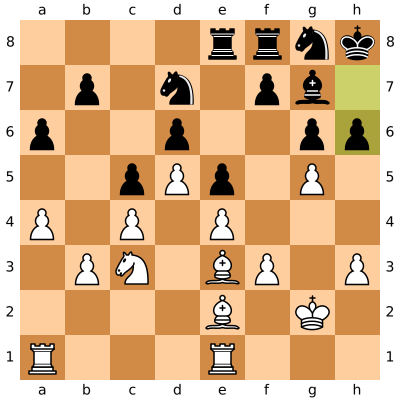

In [30]:
jogo_ate_i(array_jogadas, )

In [31]:
def convencional2afonso(string):
    return (8 - int(string[1]), ord(string[0]) - ord("a"))

In [32]:
array_jogadas

array(['d2d4', 'g8f6', 'c2c4', 'g7g6', 'b1c3', 'f8g7', 'e2e4', 'd7d6',
       'g1f3', 'e8g8', 'f1e2', 'c7c5', 'e1g1', 'c8g4', 'd4d5', 'b8d7',
       'c1g5', 'a7a6', 'a2a4', 'd8c7', 'd1d2', 'a8e8', 'h2h3', 'g4f3',
       'e2f3', 'e7e6', 'b2b3', 'g8h8', 'g5e3', 'f6g8', 'f3e2', 'e6e5',
       'g2g4', 'c7d8', 'g1g2', 'd8h4', 'f2f3', 'g7h6', 'g4g5', 'h6g7',
       'e3f2', 'h4f4', 'f2e3', 'f4h4', 'd2e1', 'h4e1', 'f1e1', 'h7h6'],
      dtype='<U4')

In [33]:
jogadas_pos = np.array([(convencional2afonso(x[:2]), convencional2afonso(x[2:])) for x in array_jogadas])

In [39]:
def paint_perspective(array_jogadas, jogada):
    jogadas_pos = np.array([(convencional2afonso(x[:2]), convencional2afonso(x[2:])) for x in array_jogadas])
    img = cv2.cvtColor(cv2.imread("Jogos/{}/{}.jpg".format(jogo, jogada)), cv2.COLOR_BGR2RGB)

    img_r = cv2.resize(img, (int(img.shape[1]/1.4), int(img.shape[0]/1.4)))
    aux = np.zeros((400, 400), dtype = np.float32)
    pts_aux = np.float32([[0,0],[aux.shape[1], 0],[aux.shape[1],aux.shape[0]],[0,aux.shape[0]]])
    
    #jogo 0 e 1
    #pts1 = np.array([[481., 156.], [852., 158.], [852., 522.], [478., 523.]], dtype = np.float32)
    pts1 = np.array([[ 49.,  71.],[282.,  73.],[280., 302.],[ 49., 301.]], dtype = np.float32)
    

    M = cv2.getPerspectiveTransform(pts1, pts_aux)
    perspectiva = cv2.warpPerspective(img_r, M,(aux.shape[1], aux.shape[0]), aux, borderMode = cv2.BORDER_TRANSPARENT)
    
    if jogada == 0:
        return perspectiva
    
    j, i = jogadas_pos[jogada-1][0]
    perspectiva = cv2.rectangle(perspectiva, (perspectiva.shape[1]*i//8, perspectiva.shape[0]*j//8), \
    (perspectiva.shape[1]*(i+1)//8, perspectiva.shape[0]*(j+1)//8), (255, 0, 0), 3)

    j, i = jogadas_pos[jogada-1][1]
    perspectiva = cv2.rectangle(perspectiva, (perspectiva.shape[1]*i//8, perspectiva.shape[0]*j//8), \
    (perspectiva.shape[1]*(i+1)//8, perspectiva.shape[0]*(j+1)//8), (0, 255, 0), 3)
    
    return perspectiva

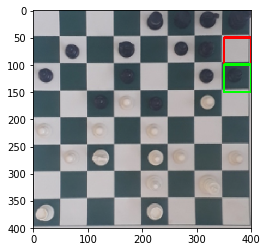

In [43]:
plt.imshow(paint_perspective(array_jogadas, 48))

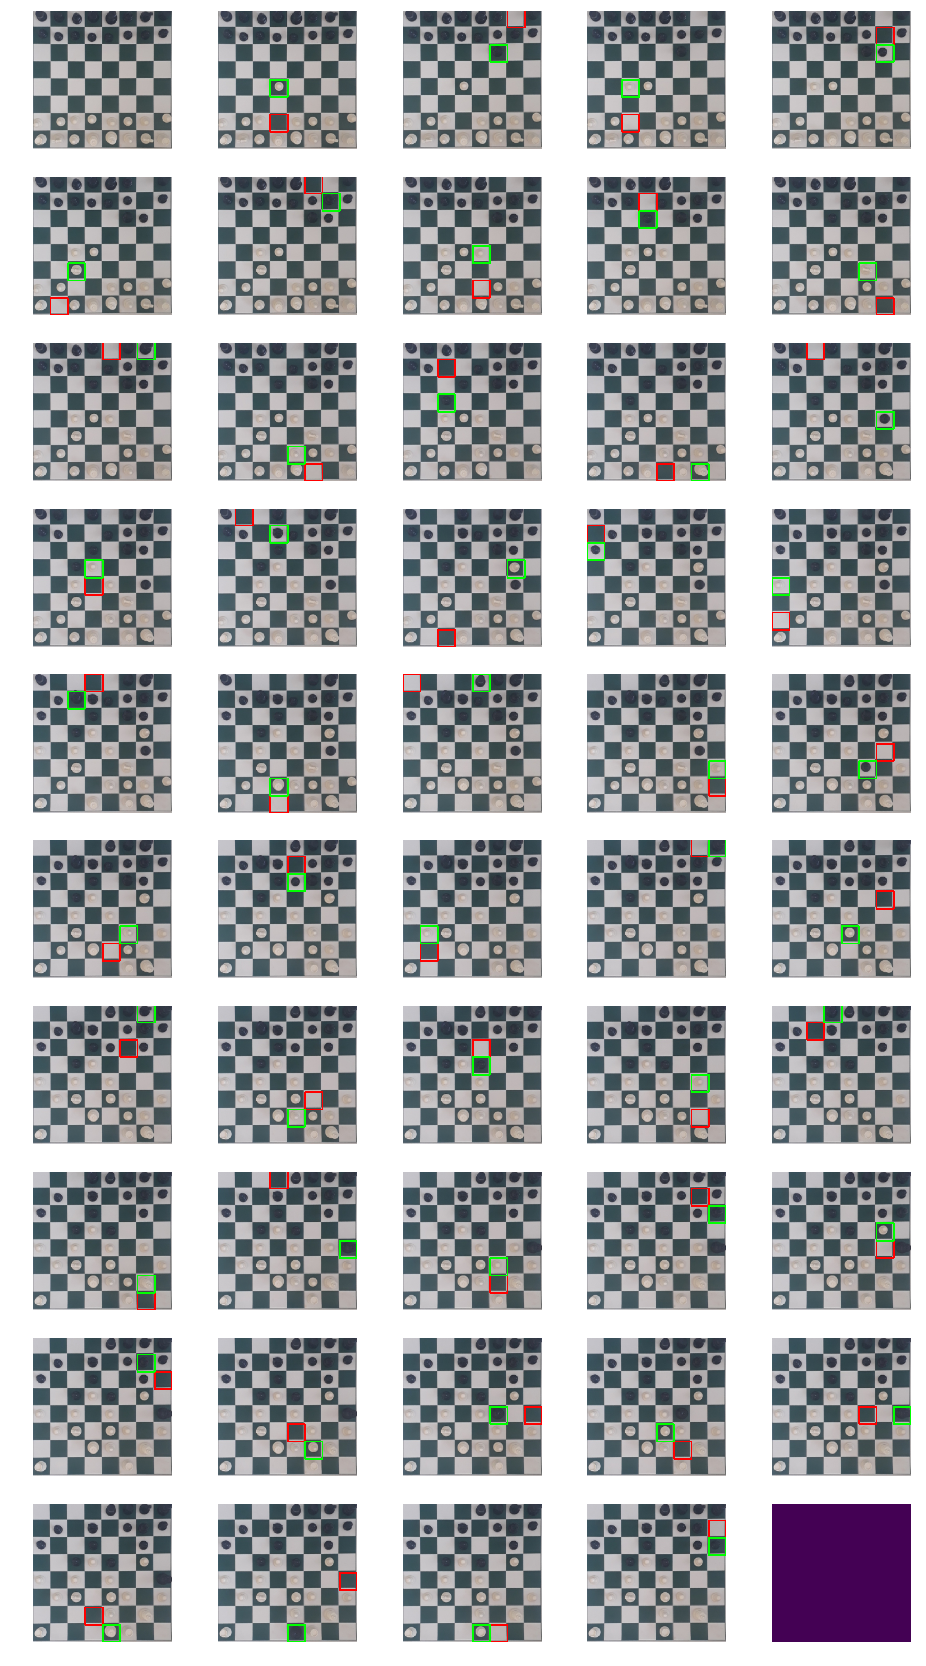

In [111]:
fig, axs = plt.subplots(10, 5, figsize = (16, 30))
[ax.set_axis_off() for ax in axs.ravel()]
#fig.set_facecolor("white")

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        ind_1d = i*axs.shape[1]+j
        if ind_1d > len(array_jogadas):
            axs[i, j].imshow(np.zeros((400, 400)))
        else:
            axs[i, j].imshow(paint_perspective(array_jogadas, ind_1d))

In [114]:
# fig.savefig("Jogos/1/geral.png", format = "png", dpi = 60)

In [162]:
engine = chess.uci.popen_engine("stockfish")
engine.uci()

In [132]:
info_handler = chess.uci.InfoHandler()
engine.info_handlers.append(info_handler)

In [147]:
board = jogo_ate_i(array_jogadas, 0)

In [148]:
engine.position(board)

In [149]:
engine.go(movetime = 1000)

BestMove(bestmove=Move.from_uci('e2e4'), ponder=Move.from_uci('e7e6'))

In [168]:
info_handler.info

{'refutation': {},
 'currline': {},
 'pv': {1: [Move.from_uci('h7h6'),
   Move.from_uci('g5e3'),
   Move.from_uci('d7b6'),
   Move.from_uci('a2a4'),
   Move.from_uci('g4f3'),
   Move.from_uci('g2f3'),
   Move.from_uci('b6d7'),
   Move.from_uci('f3f4'),
   Move.from_uci('d8c7'),
   Move.from_uci('a4a5'),
   Move.from_uci('a8e8'),
   Move.from_uci('f1e1'),
   Move.from_uci('e7e6'),
   Move.from_uci('e2f3'),
   Move.from_uci('e6e5'),
   Move.from_uci('f4f5'),
   Move.from_uci('g6f5'),
   Move.from_uci('e4f5')]},
 'score': {1: Score(cp=-81, mate=None)},
 'depth': 16,
 'seldepth': 25,
 'nodes': 960333,
 'nps': 1243954,
 'tbhits': 0,
 'time': 772,
 'multipv': 1}

In [183]:
engine = chess.uci.popen_engine("stockfish")
engine.uci()
info_handler = chess.uci.InfoHandler()
engine.info_handlers.append(info_handler)

lst_evals = []
with tqdm(total = len(array_jogadas)) as pbar:
    for i in range(len(array_jogadas)):
        board = jogo_ate_i(array_jogadas, i)
        engine.position(board)
        engine.go(movetime = 1000)
        #print(i)
        print(info_handler.info["score"][1])
        lst_evals.append((info_handler.info["score"][1].cp, info_handler.info["score"][1].mate))
        pbar.update(1)

  2%|▏         | 1/48 [00:01<00:47,  1.01s/it]

Score(cp=17, mate=None)


  4%|▍         | 2/48 [00:02<00:46,  1.01s/it]

Score(cp=-22, mate=None)


  6%|▋         | 3/48 [00:03<00:45,  1.00s/it]

Score(cp=22, mate=None)


  8%|▊         | 4/48 [00:04<00:44,  1.01s/it]

Score(cp=-31, mate=None)


 10%|█         | 5/48 [00:05<00:43,  1.00s/it]

Score(cp=47, mate=None)


 12%|█▎        | 6/48 [00:06<00:42,  1.01s/it]

Score(cp=-60, mate=None)


 15%|█▍        | 7/48 [00:07<00:41,  1.01s/it]

Score(cp=54, mate=None)


 17%|█▋        | 8/48 [00:08<00:40,  1.00s/it]

Score(cp=-55, mate=None)


 19%|█▉        | 9/48 [00:09<00:39,  1.01s/it]

Score(cp=66, mate=None)


 21%|██        | 10/48 [00:10<00:38,  1.01s/it]

Score(cp=-57, mate=None)


 23%|██▎       | 11/48 [00:11<00:37,  1.01s/it]

Score(cp=57, mate=None)


 25%|██▌       | 12/48 [00:12<00:36,  1.00s/it]

Score(cp=-49, mate=None)


 27%|██▋       | 13/48 [00:13<00:35,  1.00s/it]

Score(cp=70, mate=None)


 29%|██▉       | 14/48 [00:14<00:34,  1.00s/it]

Score(cp=-59, mate=None)


 31%|███▏      | 15/48 [00:15<00:33,  1.01s/it]

Score(cp=75, mate=None)


 33%|███▎      | 16/48 [00:16<00:32,  1.00s/it]

Score(cp=-86, mate=None)


 35%|███▌      | 17/48 [00:17<00:31,  1.00s/it]

Score(cp=76, mate=None)


 38%|███▊      | 18/48 [00:18<00:30,  1.01s/it]

Score(cp=-68, mate=None)


 40%|███▉      | 19/48 [00:19<00:29,  1.01s/it]

Score(cp=66, mate=None)


 42%|████▏     | 20/48 [00:20<00:28,  1.01s/it]

Score(cp=-64, mate=None)


 44%|████▍     | 21/48 [00:21<00:27,  1.01s/it]

Score(cp=66, mate=None)


 46%|████▌     | 22/48 [00:22<00:26,  1.00s/it]

Score(cp=-68, mate=None)


 48%|████▊     | 23/48 [00:23<00:25,  1.00s/it]

Score(cp=53, mate=None)


 50%|█████     | 24/48 [00:24<00:24,  1.00s/it]

Score(cp=-35, mate=None)


 52%|█████▏    | 25/48 [00:25<00:23,  1.01s/it]

Score(cp=44, mate=None)


 54%|█████▍    | 26/48 [00:26<00:22,  1.01s/it]

Score(cp=-51, mate=None)


 56%|█████▋    | 27/48 [00:27<00:21,  1.01s/it]

Score(cp=33, mate=None)


 58%|█████▊    | 28/48 [00:28<00:20,  1.00s/it]

Score(cp=-36, mate=None)


 60%|██████    | 29/48 [00:29<00:19,  1.00s/it]

Score(cp=80, mate=None)


 62%|██████▎   | 30/48 [00:30<00:18,  1.00s/it]

Score(cp=-35, mate=None)


 65%|██████▍   | 31/48 [00:31<00:17,  1.01s/it]

Score(cp=64, mate=None)


 67%|██████▋   | 32/48 [00:32<00:16,  1.00s/it]

Score(cp=-4, mate=None)


 69%|██████▉   | 33/48 [00:33<00:15,  1.00s/it]

Score(cp=65, mate=None)


 71%|███████   | 34/48 [00:34<00:14,  1.01s/it]

Score(cp=-48, mate=None)


 73%|███████▎  | 35/48 [00:35<00:13,  1.01s/it]

Score(cp=42, mate=None)


 75%|███████▌  | 36/48 [00:36<00:12,  1.01s/it]

Score(cp=-37, mate=None)


 77%|███████▋  | 37/48 [00:37<00:11,  1.00s/it]

Score(cp=34, mate=None)


 79%|███████▉  | 38/48 [00:38<00:10,  1.00s/it]

Score(cp=-49, mate=None)


 81%|████████▏ | 39/48 [00:39<00:09,  1.01s/it]

Score(cp=132, mate=None)


 83%|████████▎ | 40/48 [00:40<00:08,  1.01s/it]

Score(cp=-151, mate=None)


 85%|████████▌ | 41/48 [00:41<00:07,  1.01s/it]

Score(cp=143, mate=None)


 88%|████████▊ | 42/48 [00:42<00:06,  1.01s/it]

Score(cp=-113, mate=None)


 90%|████████▉ | 43/48 [00:43<00:05,  1.01s/it]

Score(cp=124, mate=None)


 92%|█████████▏| 44/48 [00:44<00:04,  1.01s/it]

Score(cp=0, mate=None)


 94%|█████████▍| 45/48 [00:45<00:03,  1.01s/it]

Score(cp=133, mate=None)


 96%|█████████▌| 46/48 [00:46<00:02,  1.01s/it]

Score(cp=-137, mate=None)


 98%|█████████▊| 47/48 [00:47<00:01,  1.01s/it]

Score(cp=127, mate=None)


100%|██████████| 48/48 [00:48<00:00,  1.01s/it]

Score(cp=-137, mate=None)


In [184]:
lst_evals

[(17, None),
 (-22, None),
 (22, None),
 (-31, None),
 (47, None),
 (-60, None),
 (54, None),
 (-55, None),
 (66, None),
 (-57, None),
 (57, None),
 (-49, None),
 (70, None),
 (-59, None),
 (75, None),
 (-86, None),
 (76, None),
 (-68, None),
 (66, None),
 (-64, None),
 (66, None),
 (-68, None),
 (53, None),
 (-35, None),
 (44, None),
 (-51, None),
 (33, None),
 (-36, None),
 (80, None),
 (-35, None),
 (64, None),
 (-4, None),
 (65, None),
 (-48, None),
 (42, None),
 (-37, None),
 (34, None),
 (-49, None),
 (132, None),
 (-151, None),
 (143, None),
 (-113, None),
 (124, None),
 (0, None),
 (133, None),
 (-137, None),
 (127, None),
 (-137, None)]

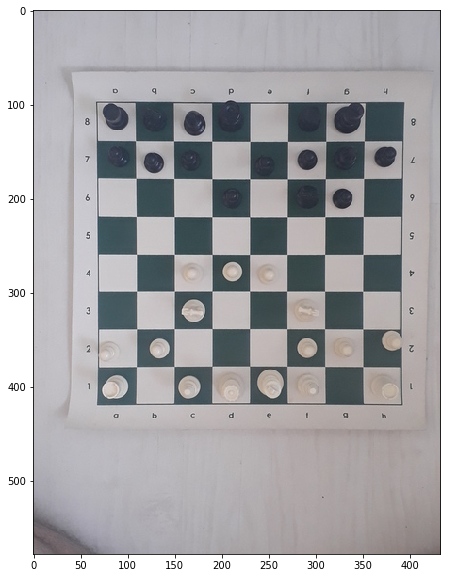

In [53]:
jogada = 10
img = cv2.cvtColor(cv2.imread("Jogos/{}/{}.jpg".format(jogo, jogada)), cv2.COLOR_BGR2RGB)
plt.figure(figsize = (10, 10))
plt.imshow(img)